In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

<h1>COVID-19 Datavisualizasion using pandas</h1>
<p>
    Data analyzation is often thought of as separated into several steps, with destinct purposes. 
    The steps I am very consious about are:
<ol>
    <li>data import</li>
    <li>data treatment/handeling/transformation and patching</li>
    <li>data visualizaison</li>
</ol>
We will here analyse some of the available data on the current covid 19 situation.
</p>

<h2>Data import</h2>
<p>
    When the data is imported, it is nice to have it update itself by simply refetch the data from their respective sources.
    Since all the differnt sourses are not necessarily compatible, some patching of the data may be required (see further below).
</p>
    
<h3>COVID-19 Data</h3>
<p>
    The COVID-19 data is imorted from the John Hopkins University, which have put their data on GitHub for Anyone to use as thy please, under the Creative Commons Attribution 4.0 International licence. You can go find the data here: 
    <a href="https://github.com/CSSEGISandData/COVID-19">https://github.com/CSSEGISandData/COVID-19</a>
</p>
<h3>Population Data</h3>
<p>
    Population data is concatinated from partially the US COVID-19 data from John Hopkins Uni. and partially from the UN population database:
    <a href="https://population.un.org/wpp/Download/Standard/Population/">https://population.un.org/wpp/Download/Standard/Population/</a>
</p>


In [2]:
# Covid data:
folder = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
confirmed_global_df = pd.read_csv(folder + "time_series_covid19_confirmed_global.csv")
confirmed_us_df = pd.read_csv(folder + "time_series_covid19_confirmed_US.csv")
deaths_global_df = pd.read_csv(folder + "time_series_covid19_deaths_global.csv")
deaths_us_df = pd.read_csv(folder + "time_series_covid19_deaths_US.csv")
# ------------------------------------------------------------------------------------------
# Population data:
folder_pop = "https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/"
#folder_pop = ""
pop_df = pd.read_csv(folder_pop + "WPP2019_TotalPopulationBySex.csv")

In [3]:
# deaths_global_df.loc[deaths_global_df["Country/Region"]=="China"]

In [4]:
# countries_list = ["Denmark", "Sweden"]
# filt = confirmed_global_df["Country/Region"].isin(countries_list)
# confirmed_global_df[filt]

<h2>Data handling and transformation</h2>
<p>
    The datahandeling treats the COVID-19 data by 2 categories: US data and (non-US)global data.
    Furthermore the population data is
</p>
    
<h3>COVID-19 Data cleaning:</h3>
<p>
    Making a new column called "Area", which contains either the numbers from "Country/Region" or "Province/State" column, depending on the convention used. 
    I like to use "Country/Region" due the the availability of population data (see later in doc).
</p>
<h4>Global (non-US) COVID-19 Data:</h4>


In [5]:
# Global data cleaning:
# Switch between Global Areas as registered nations or individual provinces/states:
# ------------------------------------------------------------------------------------------
convention_global = "Country/Region"
#convention_global = "Province/State"
# ------------------------------------------------------------------------------------------
confirmed_global_df["Province/State"] = confirmed_global_df["Province/State"].fillna(confirmed_global_df["Country/Region"])
deaths_global_df["Province/State"] = deaths_global_df["Province/State"].fillna(deaths_global_df["Country/Region"])

confirmed_global_df = pd.DataFrame(confirmed_global_df.groupby(["Country/Region", "Province/State"]).sum().reset_index())
confirmed_global_df["Area"] = confirmed_global_df[convention_global]
deaths_global_df = pd.DataFrame(deaths_global_df.groupby(["Country/Region", "Province/State"]).sum().reset_index())
deaths_global_df["Area"] = deaths_global_df[convention_global]


<h4>US Covid-19 Data:</h4>
<!--
<p>
    Same as above:
</p>
-->

In [6]:
# US data cleaning:
# dropcolumns_us = ["UID", "iso2", "iso3", "code3", "FIPS", "Admin2", "Lat", "Long_", "Combined_Key"] # old?
renaming_us = {"Province_State": "Province/State", "Country_Region": "Country/Region", "Long_": "Long"}
# ------------------------------------------------------------------------------------------
confirmed_us_df.rename(columns=renaming_us, inplace=True)
deaths_us_df.rename(columns=renaming_us, inplace=True)

############################################################################################

# Switch between US as one nation or individual states:
# ------------------------------------------------------------------------------------------
convention_us = "Country/Region"
#convention_us = "Province/State"
# ------------------------------------------------------------------------------------------
confirmed_us_df = pd.DataFrame(confirmed_us_df.groupby(["Country/Region", "Province/State"]).sum().reset_index())
confirmed_us_df["Area"] = confirmed_us_df[convention_us]

deaths_us_df = pd.DataFrame(deaths_us_df.groupby(["Country/Region", "Province/State"]).sum().reset_index())
deaths_us_df["Area"] = deaths_us_df[convention_us]
# -----------------------------------------------------------------------------------------
# Get us population data from covid dataset.
us_pop = deaths_us_df["Population"]

In [7]:
# Make unified datasets:
############################################################################################

# meta_confirmed_df.columns are the ones to drop!
dropcolumns_global = ["Lat", "Long", "Province/State", "Country/Region"] # , "Population"]
#dropcolumns_us = ["UID", "iso2", "iso3", "code3", "FIPS", "Admin2", "Lat", "Long", "Combined_Key", 
                  # "Province/State", "Country/Region"] # old?
dropcolumns_us = ["UID", "code3", "FIPS"] + dropcolumns_global

confirmed_global_df.drop(columns=dropcolumns_global, inplace=True)
deaths_global_df.drop(columns=dropcolumns_global, inplace=True)
confirmed_us_df.drop(columns=dropcolumns_us, inplace=True)
deaths_us_df.drop(columns=dropcolumns_us + ["Population"], inplace=True)

confirmed_df = pd.concat([confirmed_global_df, confirmed_us_df], sort=False)
deaths_df = pd.concat([deaths_global_df, deaths_us_df], sort=False)

confirmed_df = pd.DataFrame(confirmed_df.groupby(["Area"]).sum().reset_index())
deaths_df = pd.DataFrame(deaths_df.groupby(["Area"]).sum().reset_index())

<h3>Population Data:</h3>

<p>
    Since this database contains population data from may years back, I grab the numbers from the newest entries globally, which is last year. 
    then the unused columns are removed, the relevant are renamed to be consistent with the other dataframes, and the data is finally scaled w. 1000, since the population data is given in units of pr. 1000 individuals.
</p>


In [8]:
# Population data cleaning:
filter_pop = (pop_df["Time"] == 2019) & (pop_df["Variant"] == "Medium") & pop_df["Location"].isin(confirmed_df["Area"])
pop_df = pop_df.loc[filter_pop]
pop_df.rename(columns={"Location": "Area"}, inplace=True)
dropcolumns_pop = ["Time", "LocID", "VarID", "Variant", "MidPeriod", "PopFemale", "PopMale", "PopDensity"]
pop_df.drop(columns=dropcolumns_pop, inplace=True)
pop_df["PopTotal"] = 1000*pop_df["PopTotal"]

<h4>Patching Population Data:</h4>
<p>
    This is not very elegant, but what I have done for some of the missing or incompatible data from the populatino database, is that i manually have looked them up, and added (a few) of these to the population dataframe. 
    this is the reason you like bigger databases (usually); all data ar normally compatible within the same database, and no manual work needs to be done. :)
</p>

In [9]:
# confirmed_df = pd.DataFrame(confirmed_df.groupby(["Area"]).sum().reset_index())
# deaths_df = pd.DataFrame(deaths_df.groupby(["Area"]).sum().reset_index())

confirmed_df.set_index("Area", inplace=True)
deaths_df.set_index("Area", inplace=True)
pop_df.set_index("Area", inplace=True)

# Manually filling in data:
# Improvements can be performed here!
pop_df.loc["US"] = [us_pop.sum()]
pop_df.loc["Iran"] = [79926270]
pop_df.loc["Russia"] = [144386830]
pop_df.loc["Venezuela"] = [28887118 ]
pop_df.loc["Korea, South"] = [51709098]
filt_norm = confirmed_df[~confirmed_df.index.isin(pop_df.index)]
# filt_norm


In [10]:
#confirmed_df#.loc[["Denmark", "Sweden"]]

<h3>Selection of (relevant) data:</h3>
<p>
    This last bit of datahandeling, is done to simply pick out the nations that we would like to investigate, and to transpose the dataframes to make the plotting a tiny bit easier wrt. syntax.
</p>

In [11]:
countries_list = ["Denmark", "Sweden", "Norway", "Finland", "Belgium", "Singapore", "Switzerland"] 
#, "US", "India", "China", "Russia"]
# filt = (deaths_df["Area"].isin(countries_list))
# deaths_df[filt]
# Convert timeseris to columns:
confirmed_df = confirmed_df.T
deaths_df = deaths_df.T
pop_df = pop_df.T
# ------------------------------------------------------------------------------------------
# Filtering process
confirmed_df = confirmed_df.loc[:, confirmed_df.columns.isin(countries_list)]
deaths_df = deaths_df.loc[:, deaths_df.columns.isin(countries_list)]

confirmed_df.set_index(pd.to_datetime(confirmed_df.index), inplace=True)
deaths_df.set_index(pd.to_datetime(deaths_df.index), inplace=True)

<h2>Visualizing the Data</h2>
<p>
    Now the fun part begins that will yield the fruits of the labour. 
</p>
<h3>Raw (cumulated) Data</h3>
<p>
    Since the data has already been filtered wrt. to the areas of interests, we can start by simply plotting the time seris, wich is pretty close to the raw data. 
    This is done for both confirmed cases and fatalities.
</p>

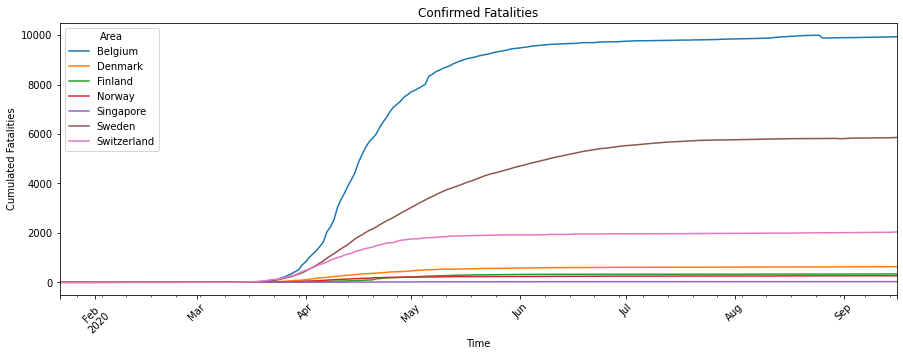

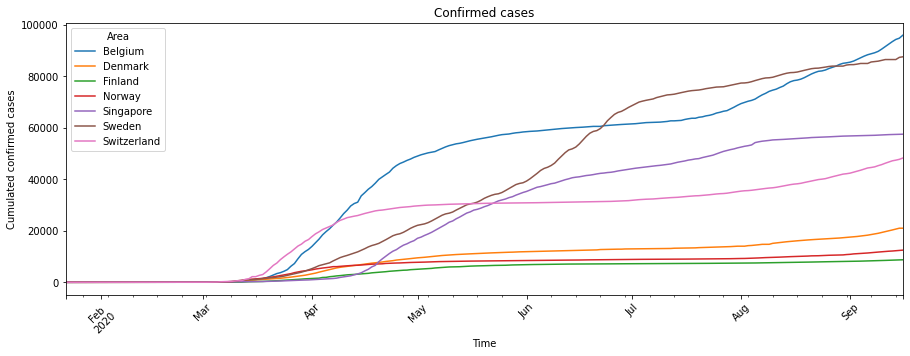

In [12]:
scaling = "linear"

deaths_df.plot(figsize=[15,5])
plt.yscale(scaling)
plt.xlabel("Time")
plt.ylabel("Cumulated Fatalities")
plt.title("Confirmed Fatalities") 
plt.xticks(rotation=45)
plt.savefig("figs/deaths_timeseries_{0}.pdf".format(scaling))
plt.show()

confirmed_df.plot(figsize=[15,5])
plt.yscale(scaling)
plt.xlabel("Time")
plt.ylabel("Cumulated confirmed cases")
plt.title("Confirmed cases") 
plt.xticks(rotation=45)
plt.savefig("figs/confirmed_timeseries_{0}.pdf".format(scaling))
plt.show()

<h3>Derivative of cumulated data:</h3>
<p>
Now, this time series is of the cumulated data, so to get a sense of the derivative (new cases pr unit of time), we sum the data of the previous week. 
This works okay, except that we experience a slight delay and smoothing of this calculated "derivative".
This is done via the function defined below, and then turned into a dataframe for plotting:
</p>

In [13]:
days_rate = 7
def make_new_pr(series):
    return [series[i]-series[0] for i in range(days_rate)] + [series[i]-series[i-days_rate] for i in range(days_rate, len(series))]
confirmed_pr_df = pd.DataFrame({c:make_new_pr(confirmed_df[c]) for c in confirmed_df.columns})
deaths_pr_df = pd.DataFrame({c: make_new_pr(deaths_df[c]) for c in deaths_df.columns})
confirmed_pr_df.set_index(confirmed_df.index, inplace=True)
deaths_pr_df.set_index(deaths_df.index, inplace=True)
# --------------------------------
# deaths_pr_df
#confirmed_pr_df[["Denmark", "Sweden"]]

In [14]:
# Make function to plot a straight line in accordance to an exponential (initial) model
# --------------------------------
# 100 linearly spaced numbers
def line(ax, min_val, max_val, k=np.log(2)):
    x = np.linspace(min_val,max_val,100)
    y = x*k # This is the value k, which i mention in the assignments
    ax.plot(x, y, "--")

And then the data is plotted:

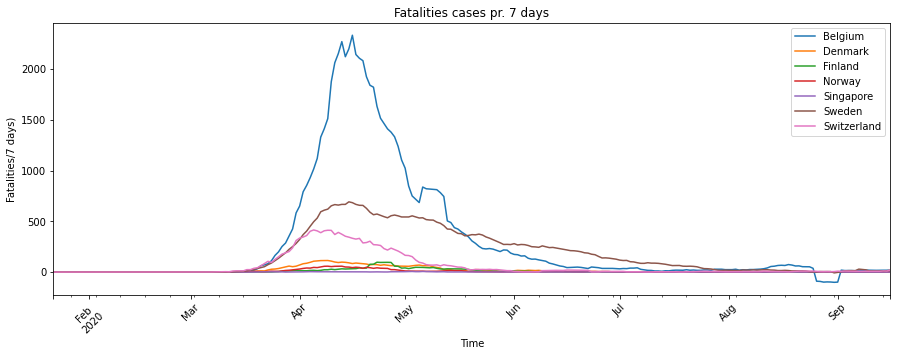

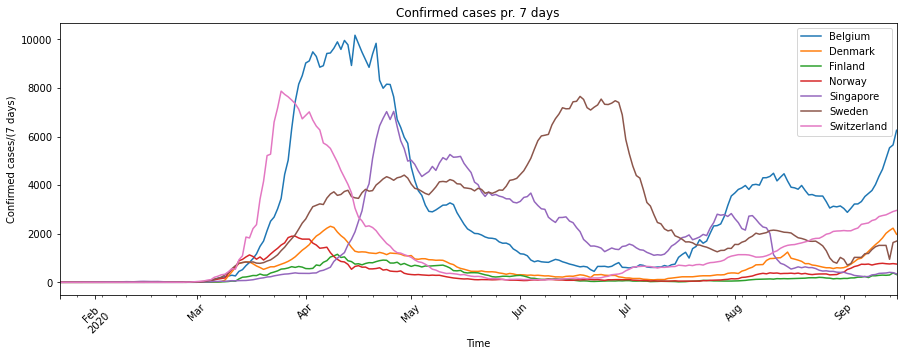

In [15]:
scaling = "linear"

deaths_pr_df.plot(figsize=[15,5])
plt.yscale(scaling)
plt.xlabel("Time")
plt.ylabel("Fatalities/{0} days)".format(days_rate))
plt.title("Fatalities cases pr. {0} days".format(days_rate)) 
plt.xticks(rotation=45)
plt.savefig("figs/deaths_rate_timeseries_{1}days_{0}.pdf".format(scaling, days_rate))
plt.show()

confirmed_pr_df.plot(figsize=[15,5])
plt.yscale(scaling)
plt.xlabel("Time")
plt.ylabel("Confirmed cases/({0} days)".format(days_rate))
plt.title("Confirmed cases pr. {0} days".format(days_rate)) 
plt.xticks(rotation=45)
plt.savefig("figs/confirmed_rate_timeseries_{1}days_{0}.pdf".format(scaling, days_rate))
plt.show()

<h3>Transformimg the visualizasion:</h3>
<p>
    Now even though the raw data looks nice, it is sometimes more usefull to transform the data or its visualizasion to extract the truely usefull information.
    What is done below is that a few things:
    The axes are changed such that:
    <ul>
    <li>x: cumulated data</li>
    <li>y: new weekly data ("drivative" of cumulated data)</li>
    <li>both axes are log-scaled.</li>
    </ul>
    This makes it easier to compare between different Areas of interests and the development of the single Area.
</p>

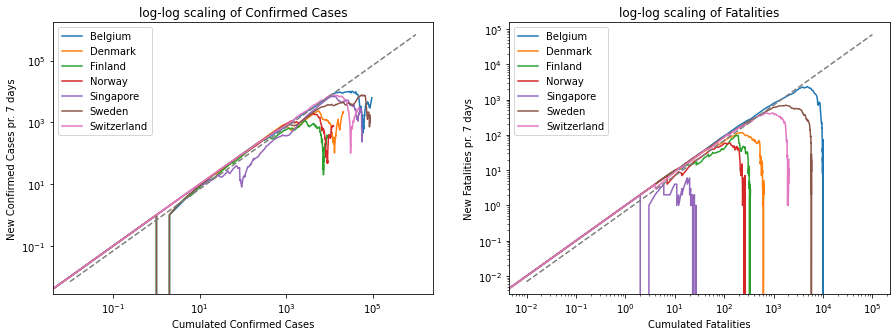

In [16]:
# Plotting results, so far:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,5])
legend_list = []
scaling = "log"
# ------------------------------------------------------------------------------------------
for c in confirmed_df.columns:
    # Make plot for confirmed cases:
    # --------------------------------
    ax1.plot(confirmed_df[c], confirmed_pr_df[c], "-")
    ax1.set_xscale(scaling)
    ax1.set_yscale(scaling)
    ax1.set_xlabel("Cumulated Confirmed Cases")
    ax1.set_ylabel("New Confirmed Cases pr. {0} days".format(days_rate))
    ax1.set_title('{0}-{0} scaling of Confirmed Cases'.format(scaling))    
    # Make plot for fatality cases:
    # --------------------------------
    ax2.plot(deaths_df[c], deaths_pr_df[c], "-")
    ax2.set_xscale(scaling)
    ax2.set_yscale(scaling)
    ax2.set_xlabel("Cumulated Fatalities")
    ax2.set_ylabel("New Fatalities pr. {0} days".format(days_rate))
    ax2.set_title('{0}-{0} scaling of Fatalities'.format(scaling))
    legend_list.append(c)
# Set legend and show:
# --------------------------------
line(ax1, 1e-2,1e6, np.log(2))
line(ax2, 1e-2,1e5, np.log(2))

ax1.legend(legend_list, loc="best")
ax2.legend(legend_list, loc="best")
plt.savefig("figs/parametric_plots_{0}.pdf".format(scaling))
plt.show()

<h3>Normalizing Data:</h3>
<p>
This might be more compact, but it is still wery easy to mistake the state in the individual countries on a relative level. For example, Which country is better/worse off pr. capita? 
To indicate this we can normalize the data series with the population size of the individual countries. 
This is what I did below:
</p>

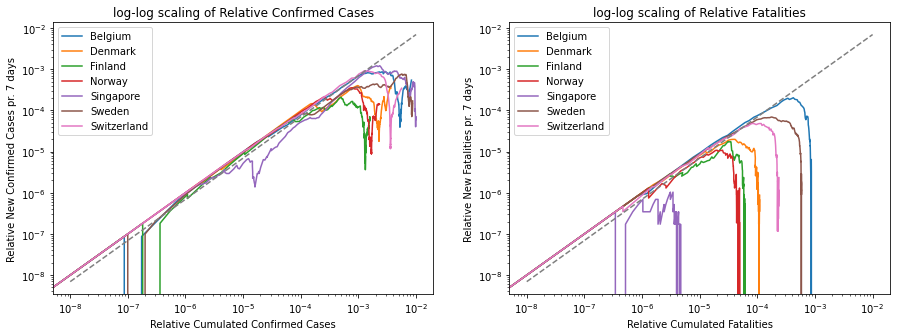

In [17]:
# Plotting results, so far:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,5])
legend_list = []
scaling = "log"
# ------------------------------------------------------------------------------------------
for c in confirmed_df.columns:
    # Make plot for confirmed cases:
    # --------------------------------
    ax1.plot(confirmed_df[c]/pop_df[c]["PopTotal"], confirmed_pr_df[c]/pop_df[c]["PopTotal"])
    ax1.set_xscale(scaling)
    ax1.set_yscale(scaling)
    ax1.set_xlabel("Relative Cumulated Confirmed Cases")
    ax1.set_ylabel("Relative New Confirmed Cases pr. {0} days".format(days_rate))
    ax1.set_title('{0}-{0} scaling of Relative Confirmed Cases'.format(scaling))    
    # Make plot for fatality cases:
    # --------------------------------
    ax2.plot(deaths_df[c]/pop_df[c]["PopTotal"], deaths_pr_df[c]/pop_df[c]["PopTotal"])
    ax2.set_xscale(scaling)
    ax2.set_yscale(scaling)
    ax2.set_xlabel("Relative Cumulated Fatalities")
    ax2.set_ylabel("Relative New Fatalities pr. {0} days".format(days_rate))
    ax2.set_title('{0}-{0} scaling of Relative Fatalities'.format(scaling))
    legend_list.append(c)

# Plotting the line as described by function defined above:
# --------------------------------
line(ax1, 1e-8,1e-2, np.log(2))
line(ax2, 1e-8,1e-2, np.log(2))

# Set legend and show:
# --------------------------------
ax1.legend(legend_list, loc="best")
ax2.legend(legend_list, loc="best")
plt.savefig("figs/parametric_plots_normalized_{0}.pdf".format(scaling))
plt.show()

One can even (attempt to) combine the two viewpoints by only normalizing the one axis i.e. the cumulative axis, and then use the y-axis to read off the absolute numbers of new weekly cases:

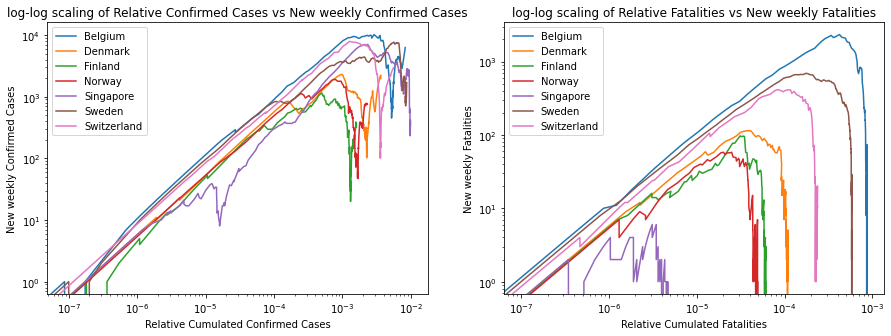

In [18]:
# Plotting results, so far:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,5])
legend_list = []
scaling = "log"
# ------------------------------------------------------------------------------------------
for c in confirmed_df.columns:
    # Make plot for confirmed cases:
    # --------------------------------
    ax1.plot(confirmed_df[c]/pop_df[c]["PopTotal"], confirmed_pr_df[c])
    ax1.set_xscale(scaling)
    ax1.set_yscale(scaling)
    ax1.set_xlabel("Relative Cumulated Confirmed Cases")
    ax1.set_ylabel("New weekly Confirmed Cases")
    ax1.set_title('{0}-{0} scaling of Relative Confirmed Cases vs New weekly Confirmed Cases'.format(scaling))    
    # Make plot for fatality cases:
    # --------------------------------
    ax2.plot(deaths_df[c]/pop_df[c]["PopTotal"], deaths_pr_df[c])
    ax2.set_xscale(scaling)
    ax2.set_yscale(scaling)
    ax2.set_xlabel("Relative Cumulated Fatalities")
    ax2.set_ylabel("New weekly Fatalities")
    ax2.set_title('{0}-{0} scaling of Relative Fatalities vs New weekly Fatalities'.format(scaling))
    legend_list.append(c)

# Set legend and show:
# --------------------------------
ax1.legend(legend_list, loc="best")
ax2.legend(legend_list, loc="best")
plt.savefig("figs/parametric_plots_semi-normalized_{0}.pdf".format(scaling))
plt.show()

The Normalizasion of data even put the raw data into a more comparative perspective wrt. each other. It provides the time series with the pr capita perspective of the different Areas. What is done below is to create dataframes with normalized data, such that the plots easily can be produced with buidin functionality of pandas module.

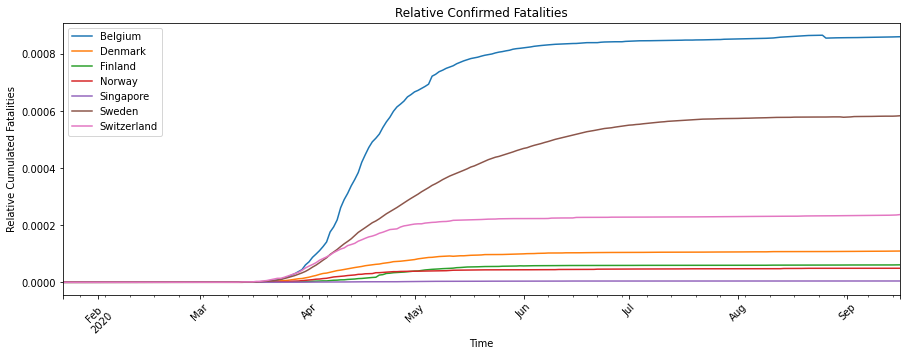

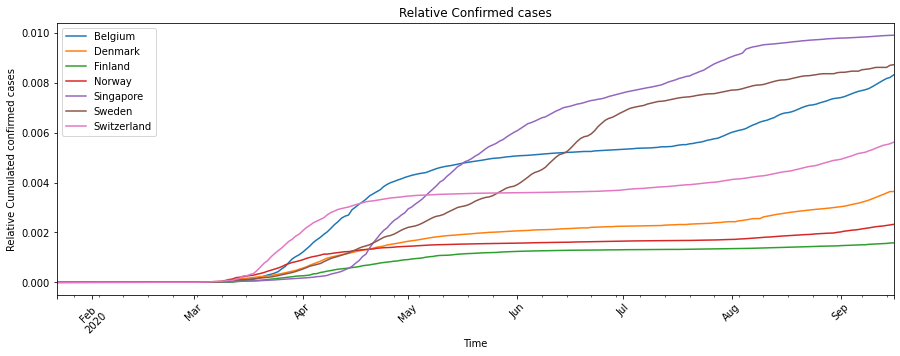

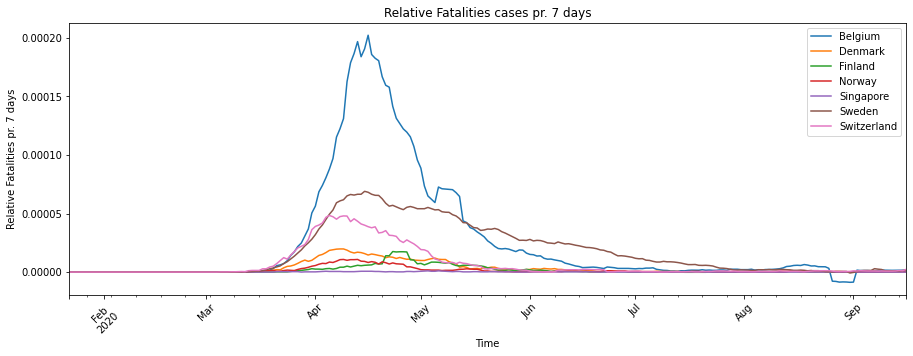

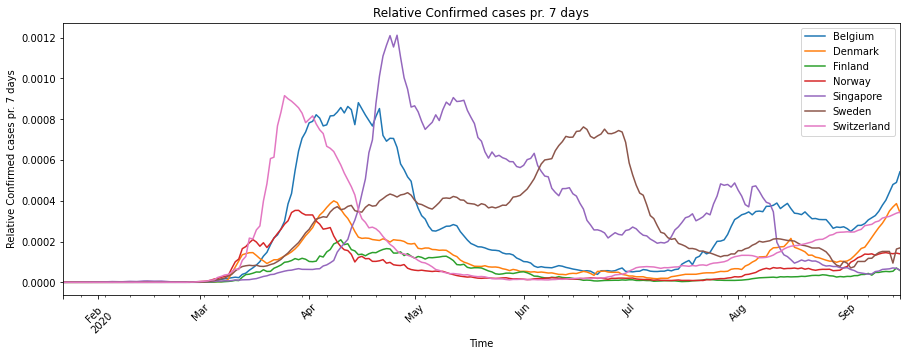

In [19]:
deaths_norm_df = pd.DataFrame()
confirmed_norm_df = pd.DataFrame()
deaths_pr_norm_df = pd.DataFrame()
confirmed_pr_norm_df = pd.DataFrame()
for c in deaths_df.columns:
    deaths_norm_df[c] = deaths_df[c]/pop_df[c]["PopTotal"]
    confirmed_norm_df[c] = confirmed_df[c]/pop_df[c]["PopTotal"]
    deaths_pr_norm_df[c] = deaths_pr_df[c]/pop_df[c]["PopTotal"]
    confirmed_pr_norm_df[c] = confirmed_pr_df[c]/pop_df[c]["PopTotal"]

scaling = "linear"
    
deaths_norm_df.plot(figsize=[15,5])
plt.xlabel("Time")
plt.ylabel("Relative Cumulated Fatalities")
plt.title("Relative Confirmed Fatalities") 
plt.xticks(rotation=45)
plt.savefig("figs/deaths_timeseries_relative_{0}.pdf".format(scaling))
plt.show()

confirmed_norm_df.plot(figsize=[15,5])
plt.xlabel("Time")
plt.ylabel("Relative Cumulated confirmed cases")
plt.title("Relative Confirmed cases") 
plt.xticks(rotation=45)
plt.savefig("figs/confirmed_timeseries_relative_{0}.pdf".format(scaling))
plt.show()

deaths_pr_norm_df.plot(figsize=[15,5])
plt.xlabel("Time")
plt.ylabel("Relative Fatalities pr. {0} days".format(days_rate))
plt.title("Relative Fatalities cases pr. {0} days".format(days_rate)) 
plt.xticks(rotation=45)
plt.savefig("figs/deaths_rate_timeseries_relative_{0}days_{1}.pdf".format(days_rate, scaling))
plt.show()

confirmed_pr_norm_df.plot(figsize=[15,5])
plt.xlabel("Time")
plt.ylabel("Relative Confirmed cases pr. {0} days".format(days_rate))
plt.title("Relative Confirmed cases pr. {0} days".format(days_rate)) 
plt.xticks(rotation=45)
plt.savefig("figs/confirmed_rate_timeseries_relative_{0}days_{1}.pdf".format(days_rate, scaling))
plt.show()

Also, one can try to compare the number of total cases to the number of fatalities and try to see the development of these two quantities:

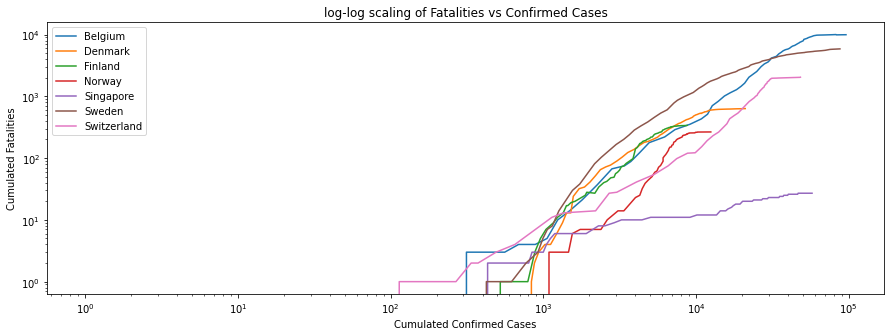

In [20]:
# Plotting results, so far:
fig, ax1 = plt.subplots(1,1, figsize=[15,5])
legend_list = []
scaling = "log"
# ------------------------------------------------------------------------------------------
for c in confirmed_df.columns:
    # Make plot for fatalities vs confirmed cases:
    # --------------------------------
    ax1.plot(confirmed_df[c], deaths_df[c], "-")
    ax1.set_xscale(scaling)
    ax1.set_yscale(scaling)
    ax1.set_xlabel("Cumulated Confirmed Cases")
    ax1.set_ylabel("Cumulated Fatalities")
    ax1.set_title('{0}-{0} scaling of Fatalities vs Confirmed Cases'.format(scaling))    
    legend_list.append(c)
# Set legend and show:
# --------------------------------
ax1.legend(legend_list, loc="best")
plt.savefig("figs/parametric_deaths_confirmed_{0}.pdf".format(scaling))
plt.show()

<h1>Exercises:</h1>
<h3>How can the behaviours of the different plots be explained? the points below is an attempt to guide you along!</h3>
<ul>
<!--<li>How do the data provide (eventual) ansvers to the behaviours?</li>-->
<!--<li>On what basis are the conclusions about the plots, drawn?</li>-->
<li>Prove to yourself that for exponential growth, the line in the log-logplot should be straight (as plotted)</li>
<li>Show that the constant $k$ is charecteristic for the the doubleing time of the numbers.</li>
<li>What should the constant $k$ be in the case of doubeling time every 2 days?</li>
<li>Use the notebook to plot the data for coutries significantly smaller and significantly larger than the ones i have chosen. how do these compare, and in what significant way do they differ. </li>
<li>Have a think about the previous problem with respect to the following: other than the log-log plots, in what other ways could you relaiably compare different nations of vastly different population sizes?</li>
<li>Why do some countries have significant higher fataly numbers than others (even when comparing nations of roghly same population sizes). What do it potentially reveal about</li>
    <ul>
        <li>demography?</li>
        <li>datacollection?</li>
        <li>testing?</li>
        <li>etc?</li>
    </ul>
<li>What do the last plot (potentially) tell us regarding the infected demography?</li>
<li>Should we be critical of the data? why?</li>
<li>Should we be critical of the conclution drawn from the data? why?</li>
<li>What other data could you wish for? why? for what?</li>
<li>Even though vague conclusions can be drawn from the data, how certain are you on these conclusions, and are some conclusions stronger than others from these data?</li>
<!--<li></li>-->
</ul>